# **Project By:**
# **Abdullah Awan 21L-5663**
# **Wara Imran 21L-6244**
# **Soha Bilal 21L-6258**



# **Important Libraries**

In [1]:
# import system libs
import os
import zipfile
import time
import shutil
import pathlib
import itertools
import csv

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image

import warnings
warnings.filterwarnings("ignore")

print('modules loaded')

modules loaded


# **Extracting Data from the zip file**

In [2]:
# Specifying the path to the zip file
zip_file_path = '/content/archive.zip'  # Change this path as per your file location

# Specifying the directory where you want to extract the files
extract_dir = '/content/extracted_files/'  # Change this path as per your desired extraction directory

# Creating the directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Extracting the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

extracted_files = os.listdir(extract_dir)
print("Extracted files:", extracted_files)

Extracted files: ['Insect Classes']


# **Function to create data frame**

In [3]:
# Generating data paths with labels
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

# Split dataframe to train, valid, and test
def split_data(data_dir):
    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    # valid and test dataframe
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df

# **Function to generate images from dataframe**

In [4]:
def create_gens (train_df, valid_df, test_df, batch_size): #This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator. Image data generator converts images into tensors.

    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

# **Function to display data sample**

In [5]:
def show_images(gen):  #This function take the data generator and show sample of the images

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # getting image index
        class_name = classes[index]   # getting class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

# **Callbacks**

In [6]:
#Callbacks : Helpful functions to help optimize model training
#Examples: stop model training after specfic time, stop training if no improve in accuracy and so on.

class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training

        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # setting highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # setting lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() #setting best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   #saving initial weights if they have to get restored

    #function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = 'Do you want model asks you to halt the training [y/n] ?'
        print(msg)
        ans = input('')
        if ans in ['Y', 'y']:
            self.ask_permission = 1
        elif ans in ['N', 'n']:
            self.ask_permission = 0

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        #setting the weights of the model to the best weights
        self.model.set_weights(self.best_weights)


    def on_train_batch_end(self, batch, logs= None):
        #to get batch accuracy and loss
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    #method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0

            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch

            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer

                else:
                    self.count = self.count + 1 # increment the patience counter

                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)

                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training

                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch {str(self.ask_epoch)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)

                        except Exception:
                            print('Invalid')

# **Function to plot history of training**

In [7]:
def plot_training(hist):   #This function take training model and plot history of accuracy and losses with the best epoch in both of them.

    #Variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    #Plotting training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

# **Function to create Confusion Matrix**

In [8]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):

	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)

	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

# **Loading Dataset**

In [15]:
data_dir = '/content/extracted_files/Insect Classes/Insect Classes'

try:
    #splitted data
    train_df, valid_df, test_df = split_data(data_dir)

    batch_size = 40
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except:
    print('Invalid Input')

Found 960 validated image filenames belonging to 10 classes.
Found 120 validated image filenames belonging to 10 classes.
Found 120 validated image filenames belonging to 10 classes.


# **Displaying Image Sample**

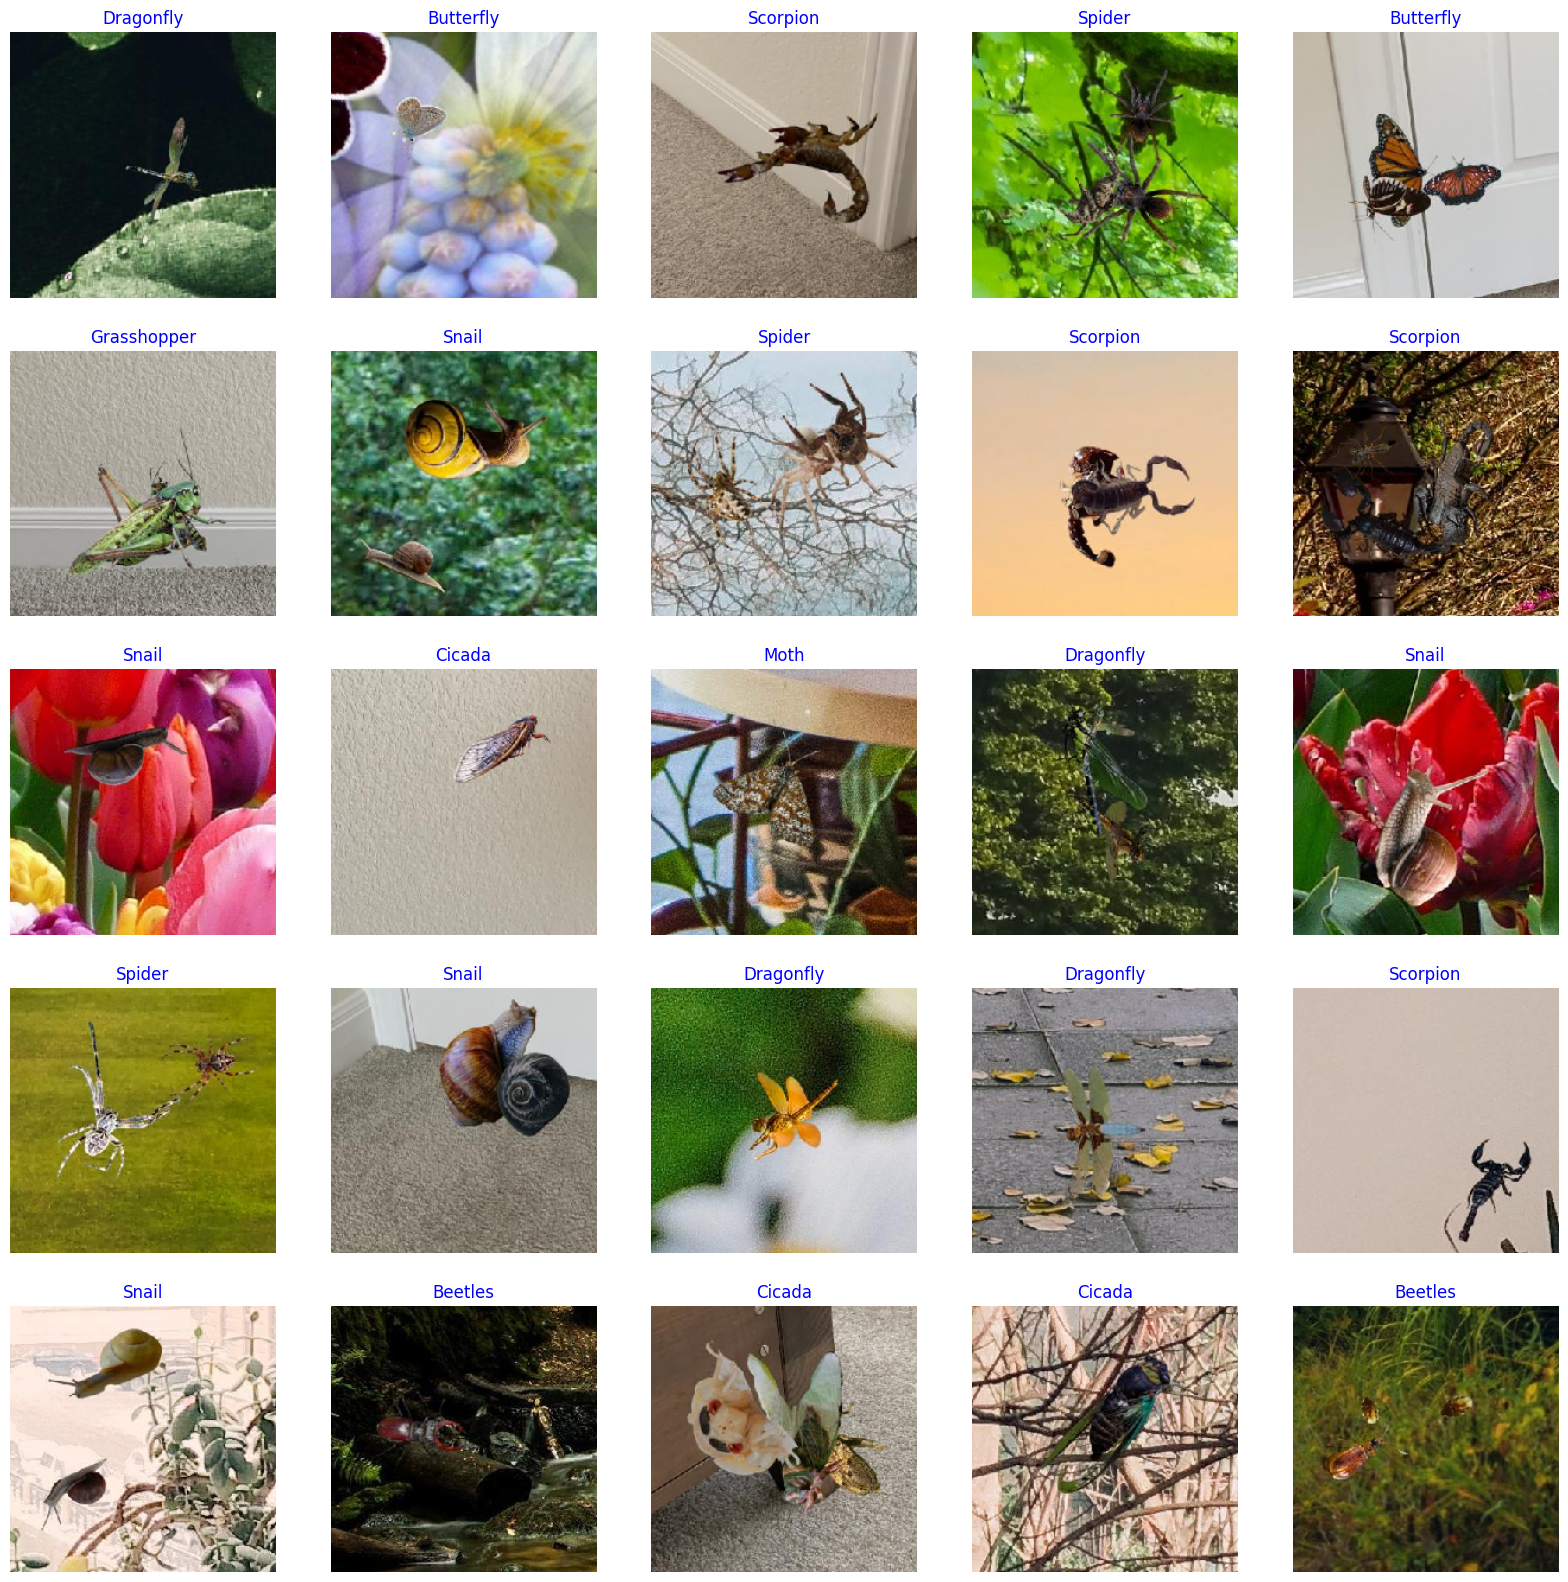

In [16]:
show_images(train_gen)

# **Creating Model (CNN)**

In [17]:
#Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) #to define number of classes in dense layer

#Using use efficientnetb3. EfficientNetB3 is a convolutional neural network architecture.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

43941136/43941136 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                         

# **Seting Callback Parameters**

In [18]:
batch_size = 40   #batch size for training
epochs = 20   #number of all epochs in training
patience = 1   #number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3   # number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9   #if train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5   #factor to reduce lr by
ask_epoch = 5   #number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))    # number of training batch to run per epoch

callbacks = [MyCallback(model= model, patience= patience, stop_patience= stop_patience, threshold= threshold,
            factor= factor, batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

# **Training model**

In [19]:
history = model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks,
                    validation_data= valid_gen, validation_steps= None, shuffle= False)

Do you want model asks you to halt the training [y/n] ?
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /20     9.729   38.333   9.88173  65.833   0.00100  0.00100  accuracy     0.00    594.91 
 2 /20     7.846   81.354   8.52017  77.500   0.00100  0.00100  accuracy    112.23   541.57 
 3 /20     7.177   90.417   7.65460  80.000   0.00100  0.00100  val_loss    10.16    532.12 
 4 /20     6.610   94.271   6.81912  85.833   0.00100  0.00100  val_loss    10.91    553.38 
 5 /20     6.165   95.729   6.32368  87.500   0.00100  0.00100  val_loss     7.27    526.24 
enter H to halt training or an integer for number of epochs to run then ask again
 training will continue until epoch 7
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 6 /20     5.728   97.812   5.92306  87.500   0.00100  0.00100  val_loss     6.34    533.49 
 7 /20     5.360   98.229   5.50998  86.667   0.00100  0.00100  val_loss     6.97 

# **Displaying model performance**

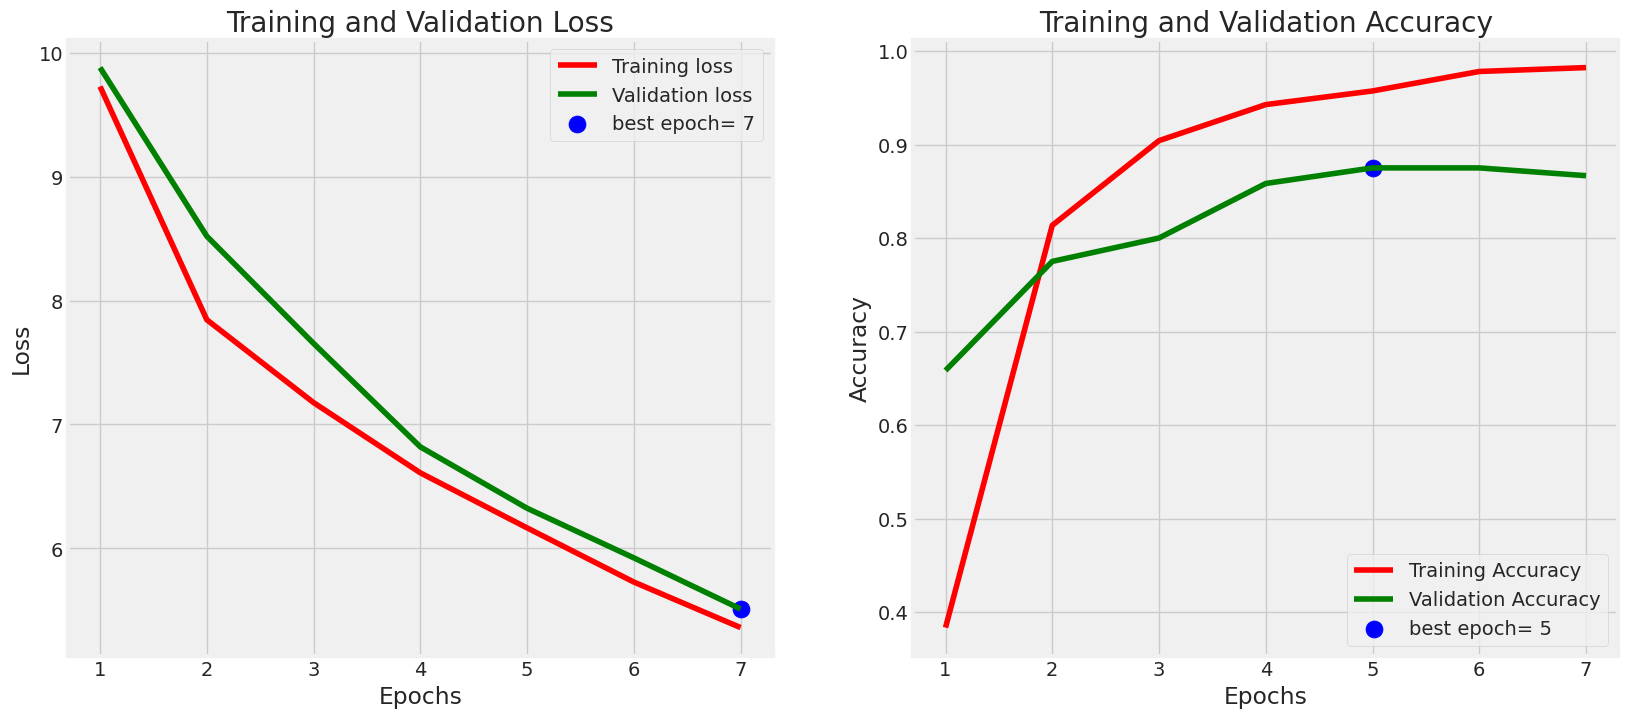

In [20]:
plot_training(history)

# **Evaluating model**

In [21]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 40)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 40)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

2/2 [==============================] - 18s 9s/step - loss: 5.4530 - accuracy: 0.8583
Train Loss:  5.126059532165527
Train Accuracy:  1.0
----------------------------------------
Validation Loss:  5.521684646606445
Validation Accuracy:  0.875
----------------------------------------
Test Loss:  5.452952861785889
Test Accuracy:  0.8583333492279053


# **Storing Predictions result**

In [23]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

[4 3 3 1 2 5 0 1 0 5 3 0 2 8 6 5 4 0 5 1 9 1 8 6 2 4 3 7 1 3 0 2 6 5 6 2 4
 5 6 9 0 4 5 3 3 9 4 8 1 3 2 4 3 3 7 7 5 4 6 3 6 5 7 5 7 7 6 9 4 8 4 7 1 4
 1 9 8 6 1 5 2 5 9 0 4 2 7 4 7 1 9 7 6 8 9 2 8 4 6 6 7 7 8 3 9 8 0 6 4 3 7
 6 8 0 0 8 4 8 5 6]


# **Confusion Matrics and Classification Report**

Confusion Matrix, Without Normalization
[[10  0  0  0  0  0  2  0  0  0]
 [ 0  9  0  1  1  1  0  0  0  0]
 [ 0  0  9  0  0  0  3  0  0  0]
 [ 0  0  0 11  1  0  0  0  0  0]
 [ 0  0  0  1 11  0  0  0  0  0]
 [ 0  0  0  0  2 10  0  0  0  0]
 [ 0  1  0  0  0  1 10  0  0  0]
 [ 0  0  0  0  0  0  0 12  0  0]
 [ 0  0  0  0  0  0  0  0 12  0]
 [ 0  0  0  0  1  1  0  1  0  9]]
              precision    recall  f1-score   support

        Bees       1.00      0.83      0.91        12
     Beetles       0.90      0.75      0.82        12
   Butterfly       1.00      0.75      0.86        12
      Cicada       0.85      0.92      0.88        12
   Dragonfly       0.69      0.92      0.79        12
 Grasshopper       0.77      0.83      0.80        12
        Moth       0.67      0.83      0.74        12
    Scorpion       0.92      1.00      0.96        12
       Snail       1.00      1.00      1.00        12
      Spider       1.00      0.75      0.86        12

    accuracy                     

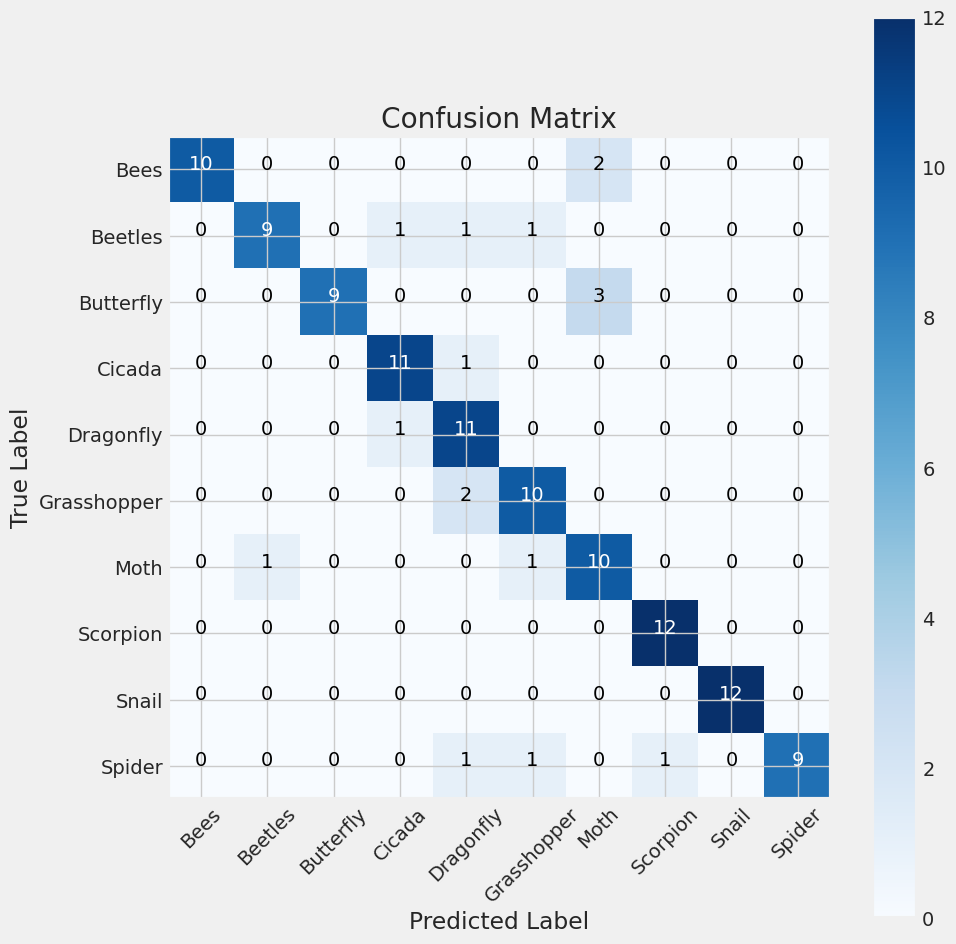

In [24]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

# **Creating a database that contains information about different insect species**

In [25]:
data = [
    [
        "Honeybee",
        "Social",
        "Collect nectar and pollen",
        "Apiaries",
        "Pollination (improves crop yield)",
        "Honeybees are social insects that live in colonies. They prefer habitats with abundant flowers for foraging.",
        "Honeybees do not cause direct damage to crops. However, their importance in pollination makes them crucial for crop production. Loss of honeybee populations can lead to decreased crop yields and biodiversity.",
        "To support honeybee populations, it's important to protect their habitats, avoid the use of pesticides harmful to bees, and provide supplementary food sources when natural forage is scarce.",
        "To prevent declines in honeybee populations, farmers can implement bee-friendly farming practices, such as planting bee-friendly crops, maintaining natural habitats, and avoiding the use of pesticides harmful to bees."
    ],
    [
        "Beetle",
        "Solitary or social",
        "Varies by species; some are herbivores, others are predators",
        "Various habitats including forests, grasslands, and gardens",
        "Some species of beetles can be beneficial as natural predators of pests, while others may cause damage to crops by feeding on plants or stored food.",
        "Beetles exhibit a wide range of behaviors and can be found in diverse habitats. Some species are beneficial as natural predators of pests, while others may cause damage to crops by feeding on plants or stored food.",
        "Beetles can cause damage to crops by feeding on plants or stored food. They may also transmit diseases to plants.",
        "Control of beetles depends on the species and the extent of damage. Biological control methods, such as introducing natural predators or parasites, may be effective for some species. Insecticides can also be used, but they should be applied selectively to avoid harming beneficial species.",
        "To prevent damage by beetles, farmers can use integrated pest management (IPM) strategies, such as monitoring beetle populations, practicing crop rotation, and maintaining good sanitation practices."
    ],
    [
        "Butterfly",
        "Solitary",
        "Adults feed on nectar, while caterpillars feed on plant leaves or flowers",
        "Various habitats including gardens, fields, forests, and meadows",
        "Butterflies are important pollinators and contribute to ecosystem health. Some species may also serve as indicators of environmental quality.",
        "Butterflies are graceful insects that can be found in diverse habitats, from gardens to forests. They are important pollinators and contribute to ecosystem health.",
        "Butterflies do not cause direct damage to crops. However, their caterpillars may feed on plant leaves or flowers.",
        "To attract butterflies to gardens, farmers can plant nectar-rich flowers and provide suitable habitat, such as native plants and sheltered areas. Avoiding the use of pesticides harmful to butterflies is also important.",
        "To support butterfly populations, farmers can create butterfly-friendly habitats by planting nectar-rich flowers, providing suitable breeding sites, and avoiding the use of pesticides harmful to butterflies."
    ],
    [
        "Cicada",
        "Solitary",
        "Feed on plant sap",
        "Tree species such as oak, maple, and pine",
        "Adult cicadas emerge from the ground in large numbers during certain years. Their loud mating calls are a natural phenomenon.",
        "Cicadas are large, noisy insects that spend most of their lives underground. They emerge in large numbers during certain years to mate and lay eggs.",
        "Cicadas do not cause direct damage to crops, but their egg-laying behavior can damage tree branches and twigs. Some species may also cause damage to ornamental plants.",
        "Control of cicadas is difficult due to their large numbers and sporadic emergence. Physical barriers, such as nets or screens, can be used to protect trees and plants from egg-laying females. Insecticides are generally not effective against adult cicadas due to their tough exoskeletons.",
        "To prevent damage by cicadas, farmers can use physical barriers to protect trees and plants from egg-laying females. Pruning trees to remove damaged branches can also help reduce damage."
    ],
    [
        "Dragonfly",
        "Predatory",
        "Feed on insects, including mosquitoes, flies, and other small prey",
        "Water bodies such as ponds, lakes, rivers, and streams",
        "Dragonflies are agile predators that hunt insects in flight. They are important natural predators of mosquitoes and other pests.",
        "Dragonflies are found near water bodies such as ponds, lakes, rivers, and streams. They are agile predators that hunt insects in flight.",
        "Dragonflies do not cause damage to crops. Instead, they provide valuable pest control by preying on mosquitoes and other insect pests.",
        "To attract dragonflies to ponds and water gardens, farmers can provide suitable habitat, such as emergent plants and rocks for perching. Avoiding the use of pesticides harmful to dragonflies is also important.",
        "To support dragonfly populations, farmers can create and maintain aquatic habitats with clean water and diverse vegetation. Avoiding the use of pesticides near water bodies is also important."
    ],
    [
        "Grasshopper",
        "Solitary",
        "Herbivorous, feeding on grasses and other plants",
        "Grasslands, meadows, fields, and gardens",
        "Grasshoppers are herbivorous insects that feed on grasses and other plants. They are agile jumpers and can cause significant damage to crops when present in large numbers.",
        "Grasshoppers are found in grasslands, meadows, fields, and gardens. They are herbivorous insects that feed on grasses and other plants.",
        "Grasshoppers can cause significant damage to crops by feeding on plant foliage. They are especially problematic in dry years when natural vegetation is scarce.",
        "Control of grasshoppers may involve cultural practices such as crop rotation and planting of trap crops. Biological control methods, such as introducing natural enemies or parasites, may also be effective. Insecticides can be used as a last resort.",
        "To prevent damage by grasshoppers, farmers can monitor populations and take action when necessary, such as using physical barriers or applying insecticides selectively."
    ],
    [
        "Moth",
        "Solitary or social",
        "Varies by species; some are herbivores, others are predators",
        "Various habitats including forests, fields, and gardens",
        "Moths are diverse insects found in various habitats around the world. They play important roles in ecosystems as pollinators, decomposers, and food sources for other animals.",
        "Moths are diverse insects found in various habitats around the world. They can be solitary or social and exhibit a wide range of behaviors.",
        "Some moth species may cause damage to crops as larvae by feeding on plant leaves, stems, or fruits. They may also damage stored food products.",
        "Control of moth pests may involve cultural practices such as sanitation and crop rotation. Biological control methods, such as introducing natural enemies or parasites, may also be effective. Insecticides can be used as a last resort.",
        "To prevent damage by moth pests, farmers can implement IPM strategies, such as monitoring moth populations, practicing good sanitation practices, and using pheromone traps."
    ],
    [
        "Scorpion",
        "Solitary or social",
        "Feed on insects and other small prey",
        "Desert regions and other dry habitats",
        "Scorpions are predatory arachnids found in desert regions and other dry habitats. They use their venomous stinger to capture and immobilize prey.",
        "Scorpions are nocturnal predators that hunt insects and other small prey. They are typically found in desert regions and other dry habitats.",
        "Scorpions can sting humans and pets, causing pain and sometimes allergic reactions. While most scorpion species are not considered agricultural pests, they can be a nuisance in and around homes.",
        "Control of scorpions may involve habitat modification, such as removing debris and sealing cracks and crevices where scorpions can hide. Insecticides can also be used to treat outdoor areas where scorpions are present.",
        "To prevent encounters with scorpions, farmers can take measures to reduce habitat around homes and buildings, such as removing debris and sealing cracks and crevices."
    ],
    [
        "Snail",
        "Solitary",
        "Herbivorous, feeding on plant leaves, stems, and fruits",
        "Moist habitats such as gardens, fields, and forests",
        "Snails are slow-moving mollusks with a shell. They are herbivorous and feed on plant leaves, stems, and fruits.",
        "Snails are found in moist habitats such as gardens, fields, and forests. They are slow-moving mollusks with a shell.",
        "Snails can cause damage to crops by feeding on plant leaves, stems, and fruits. They are especially problematic in wet conditions when populations are high.",
        "Control of snails may involve cultural practices such as handpicking and removing debris where snails hide. Biological control methods, such as introducing natural enemies or parasites, may also be effective. Insecticides can be used as a last resort.",
        "To prevent damage by snails, farmers can implement cultural practices such as removing debris and providing barriers to protect vulnerable plants."
    ],
    [
        "Spider",
        "Solitary",
        "Feed on insects and other small prey",
        "Various habitats including forests, fields, and gardens",
        "Spiders are predatory arachnids that play important roles in ecosystems as natural pest controllers. They use silk to build webs for capturing prey.",
        "Spiders are found in various habitats around the world. They are solitary predators that feed on insects and other small prey.",
        "Spiders do not cause damage to crops. Instead, they provide valuable pest control by preying on insects and other small pests.",
        "To attract spiders to gardens and fields, farmers can provide suitable habitat, such as vegetation and sheltered areas. Avoiding the use of pesticides harmful to spiders is also important.",
        "To support spider populations, farmers can create and maintain diverse habitats with vegetation and sheltered areas. Avoiding the use of pesticides near spider habitats is also important."
    ]
]

csv_file = "Specie_database.csv"

with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([
        "Species", "Behavior", "Diet", "Habitat", "Impact_on_Crops",
        "Behavior_and_Habitat", "Damage_Assessment",
        "Control_and_Management", "Preventive_Measures"
    ])
    writer.writerows(data)

print("Data has been successfully stored in", csv_file)

Data has been successfully stored in Specie_database.csv


# **Testing the model and predicting the class of input image**

1/1 [==============================] - 7s 7s/step


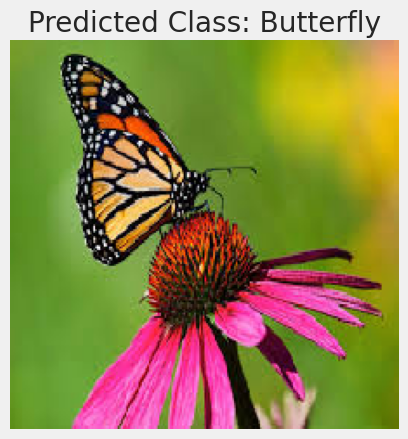

Confidence Scores: [[0.00677467 0.00307589 0.9212717  0.00147074 0.00133289 0.01493351
  0.00910142 0.00886866 0.00254205 0.03062845]]


In [26]:
# Function to preprocess the image
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Function to make predictions
def predict_image(model, image_path, class_indices):
    img = preprocess_image(image_path)
    predictions = model.predict(img)
    predicted_class = np.argmax(predictions)
    class_name = list(class_indices.keys())[predicted_class]
    return class_name, predictions, img

image_path = "/content/img.jfif"

predicted_class, predictions, img = predict_image(model, image_path, train_gen.class_indices)

plt.imshow(img.squeeze().astype(np.uint8))
plt.title("Predicted Class: " + predicted_class)
plt.axis('off')
plt.show()

print("Confidence Scores:", predictions)

# **Specie details and impact assessment for home farmers after detecting the species of insect**

In [28]:
df = pd.read_csv("Specie_database.csv")

species_details = df[df["Species"] == predicted_class]

print("Species Details:")
for index, row in species_details.iterrows():
    print("Species:", row["Species"])
    print("Behavior:", row["Behavior"])
    print("Diet:", row["Diet"])
    print("Habitat:", row["Habitat"])
    print("Impact on Crops:", row["Impact_on_Crops"])
    print("Behavior and Habitat:", row["Behavior_and_Habitat"])
    print("Damage Assessment:", row["Damage_Assessment"])
    print("Control and Management:", row["Control_and_Management"])
    print("Preventive Measures:", row["Preventive_Measures"])
    print("-" * 300)

Species Details:
Species: Butterfly
Behavior: Solitary
Diet: Adults feed on nectar, while caterpillars feed on plant leaves or flowers
Habitat: Various habitats including gardens, fields, forests, and meadows
Impact on Crops: Butterflies are important pollinators and contribute to ecosystem health. Some species may also serve as indicators of environmental quality.
Behavior and Habitat: Butterflies are graceful insects that can be found in diverse habitats, from gardens to forests. They are important pollinators and contribute to ecosystem health.
Damage Assessment: Butterflies do not cause direct damage to crops. However, their caterpillars may feed on plant leaves or flowers.
Control and Management: To attract butterflies to gardens, farmers can plant nectar-rich flowers and provide suitable habitat, such as native plants and sheltered areas. Avoiding the use of pesticides harmful to butterflies is also important.
Preventive Measures: To support butterfly populations, farmers can cre

# **Predictions**

1/1 [==============================] - 1s 631ms/step


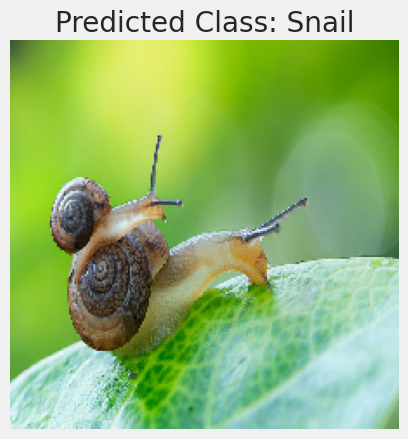

Confidence Scores: [[2.5295606e-04 1.9021408e-04 1.1385417e-03 4.3737724e-05 2.1622896e-03
  1.1086976e-04 2.7586523e-04 1.3890027e-04 9.9518365e-01 5.0300348e-04]]


In [29]:
# Function to preprocess the image
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Function to make predictions
def predict_image(model, image_path, class_indices):
    img = preprocess_image(image_path)
    predictions = model.predict(img)
    predicted_class = np.argmax(predictions)
    class_name = list(class_indices.keys())[predicted_class]
    return class_name, predictions, img

image_path = "/content/snail.webp"

predicted_class, predictions, img = predict_image(model, image_path, train_gen.class_indices)

plt.imshow(img.squeeze().astype(np.uint8))
plt.title("Predicted Class: " + predicted_class)
plt.axis('off')
plt.show()

print("Confidence Scores:", predictions)

1/1 [==============================] - 0s 284ms/step


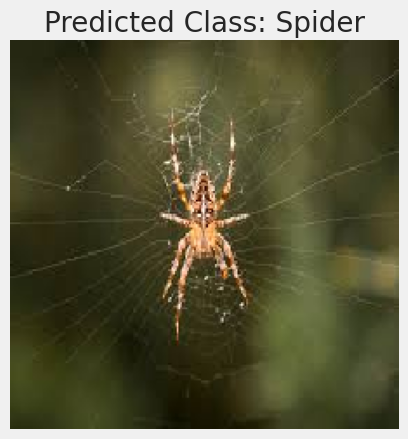

Confidence Scores: [[1.7753256e-03 3.6861983e-04 2.8764075e-04 1.4802086e-03 3.1561343e-04
  2.7704512e-04 5.1169691e-04 4.1801782e-04 4.1486998e-04 9.9415094e-01]]


In [31]:
# Function to preprocess the image
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Function to make predictions
def predict_image(model, image_path, class_indices):
    img = preprocess_image(image_path)
    predictions = model.predict(img)
    predicted_class = np.argmax(predictions)
    class_name = list(class_indices.keys())[predicted_class]
    return class_name, predictions, img

image_path = "/content/spider.jfif"

predicted_class, predictions, img = predict_image(model, image_path, train_gen.class_indices)

plt.imshow(img.squeeze().astype(np.uint8))
plt.title("Predicted Class: " + predicted_class)
plt.axis('off')
plt.show()

print("Confidence Scores:", predictions)

1/1 [==============================] - 0s 287ms/step


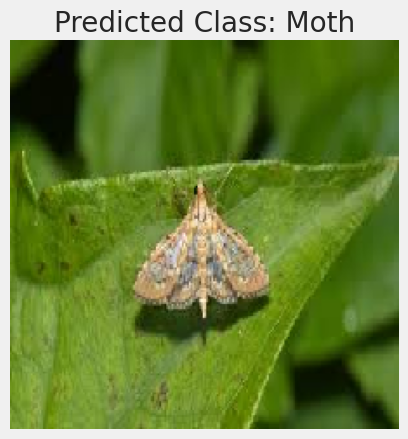

Confidence Scores: [[1.8818193e-05 7.8147408e-05 1.8338969e-03 7.6026833e-03 3.2870803e-04
  2.3217509e-03 9.7401017e-01 1.9109916e-04 5.1650510e-05 1.3563035e-02]]


In [32]:
# Function to preprocess the image
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Function to make predictions
def predict_image(model, image_path, class_indices):
    img = preprocess_image(image_path)
    predictions = model.predict(img)
    predicted_class = np.argmax(predictions)
    class_name = list(class_indices.keys())[predicted_class]
    return class_name, predictions, img

image_path = "/content/moth.jfif"

predicted_class, predictions, img = predict_image(model, image_path, train_gen.class_indices)

plt.imshow(img.squeeze().astype(np.uint8))
plt.title("Predicted Class: " + predicted_class)
plt.axis('off')
plt.show()

print("Confidence Scores:", predictions)

1/1 [==============================] - 0s 228ms/step


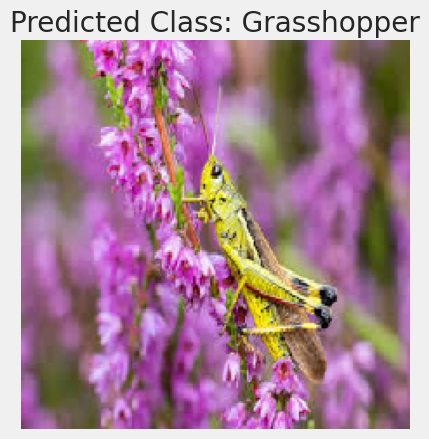

Confidence Scores: [[4.8423262e-05 1.5236037e-05 2.8751159e-05 1.7234703e-05 7.2255178e-05
  9.9976295e-01 2.8203976e-06 1.5368516e-05 2.8619861e-06 3.4083183e-05]]


In [34]:
# Function to preprocess the image
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Function to make predictions
def predict_image(model, image_path, class_indices):
    img = preprocess_image(image_path)
    predictions = model.predict(img)
    predicted_class = np.argmax(predictions)
    class_name = list(class_indices.keys())[predicted_class]
    return class_name, predictions, img

image_path = "/content/GH.jfif"

predicted_class, predictions, img = predict_image(model, image_path, train_gen.class_indices)

plt.imshow(img.squeeze().astype(np.uint8))
plt.title("Predicted Class: " + predicted_class)
plt.axis('off')
plt.show()

print("Confidence Scores:", predictions)

1/1 [==============================] - 0s 216ms/step


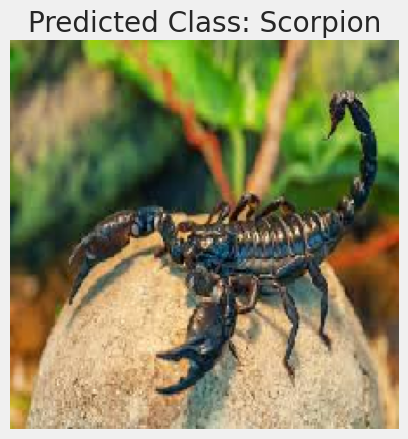

Confidence Scores: [[2.6648822e-03 3.0139700e-04 1.6511619e-03 4.9829896e-04 1.8775966e-03
  4.9037104e-03 8.6460226e-05 9.8630941e-01 1.2467951e-04 1.5823098e-03]]


In [35]:
# Function to preprocess the image
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Function to make predictions
def predict_image(model, image_path, class_indices):
    img = preprocess_image(image_path)
    predictions = model.predict(img)
    predicted_class = np.argmax(predictions)
    class_name = list(class_indices.keys())[predicted_class]
    return class_name, predictions, img

image_path = "/content/scorpion.jfif"

predicted_class, predictions, img = predict_image(model, image_path, train_gen.class_indices)

plt.imshow(img.squeeze().astype(np.uint8))
plt.title("Predicted Class: " + predicted_class)
plt.axis('off')
plt.show()

print("Confidence Scores:", predictions)

1/1 [==============================] - 0s 286ms/step


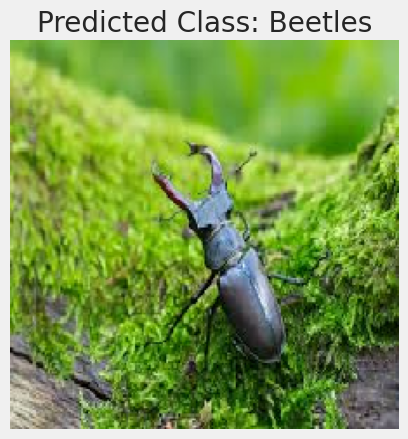

Confidence Scores: [[3.7276049e-04 9.8375517e-01 4.9617502e-04 2.0859865e-03 6.9365121e-04
  8.0631189e-03 3.1081971e-04 1.3771493e-03 1.5975774e-03 1.2475617e-03]]


In [36]:
# Function to preprocess the image
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Function to make predictions
def predict_image(model, image_path, class_indices):
    img = preprocess_image(image_path)
    predictions = model.predict(img)
    predicted_class = np.argmax(predictions)
    class_name = list(class_indices.keys())[predicted_class]
    return class_name, predictions, img

image_path = "/content/beetle.jfif"

predicted_class, predictions, img = predict_image(model, image_path, train_gen.class_indices)

plt.imshow(img.squeeze().astype(np.uint8))
plt.title("Predicted Class: " + predicted_class)
plt.axis('off')
plt.show()

print("Confidence Scores:", predictions)

1/1 [==============================] - 0s 230ms/step


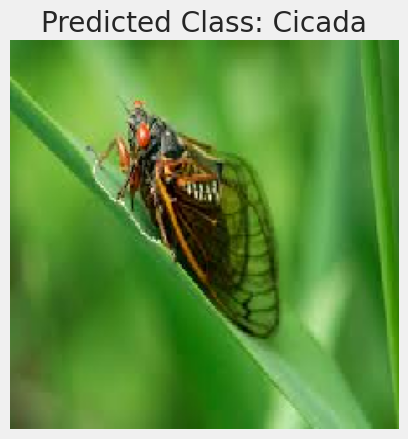

Confidence Scores: [[1.7116074e-03 6.9627957e-03 1.4549033e-01 7.2088999e-01 2.0792134e-02
  7.9616457e-02 3.1410116e-03 1.9541336e-02 3.1442195e-04 1.5399245e-03]]


In [37]:
# Function to preprocess the image
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Function to make predictions
def predict_image(model, image_path, class_indices):
    img = preprocess_image(image_path)
    predictions = model.predict(img)
    predicted_class = np.argmax(predictions)
    class_name = list(class_indices.keys())[predicted_class]
    return class_name, predictions, img

image_path = "/content/cicada.jfif"

predicted_class, predictions, img = predict_image(model, image_path, train_gen.class_indices)

plt.imshow(img.squeeze().astype(np.uint8))
plt.title("Predicted Class: " + predicted_class)
plt.axis('off')
plt.show()

print("Confidence Scores:", predictions)

1/1 [==============================] - 0s 312ms/step


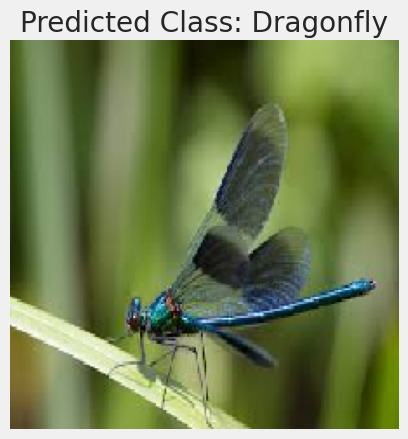

Confidence Scores: [[0.00637895 0.08226129 0.06066562 0.24000701 0.38368303 0.05104698
  0.03185645 0.03243165 0.02925014 0.08241886]]


In [38]:
# Function to preprocess the image
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Function to make predictions
def predict_image(model, image_path, class_indices):
    img = preprocess_image(image_path)
    predictions = model.predict(img)
    predicted_class = np.argmax(predictions)
    class_name = list(class_indices.keys())[predicted_class]
    return class_name, predictions, img

image_path = "/content/DF.jfif"

predicted_class, predictions, img = predict_image(model, image_path, train_gen.class_indices)

plt.imshow(img.squeeze().astype(np.uint8))
plt.title("Predicted Class: " + predicted_class)
plt.axis('off')
plt.show()

print("Confidence Scores:", predictions)

1/1 [==============================] - 0s 255ms/step


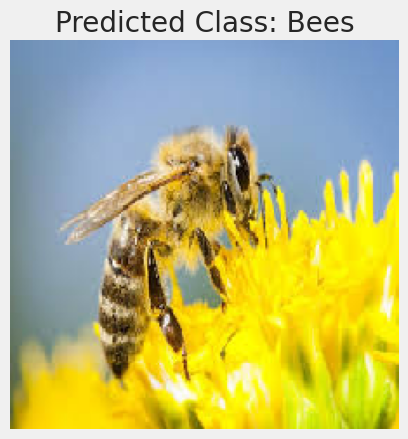

Confidence Scores: [[0.18625653 0.06393465 0.06925123 0.07258032 0.17470676 0.12058844
  0.13108496 0.01295476 0.06210557 0.10653684]]


In [39]:
# Function to preprocess the image
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Function to make predictions
def predict_image(model, image_path, class_indices):
    img = preprocess_image(image_path)
    predictions = model.predict(img)
    predicted_class = np.argmax(predictions)
    class_name = list(class_indices.keys())[predicted_class]
    return class_name, predictions, img

image_path = "/content/bee.jfif"

predicted_class, predictions, img = predict_image(model, image_path, train_gen.class_indices)

plt.imshow(img.squeeze().astype(np.uint8))
plt.title("Predicted Class: " + predicted_class)
plt.axis('off')
plt.show()

print("Confidence Scores:", predictions)